# Communication graph

BONUS: Build the communication graph (unweighted and undirected) among the different email senders and recipients using the NetworkX library. Find communities in this graph with community.best_partition(G) method from the community detection module. Print the most frequent 20 words used by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA? Can you identify clear discussion topics for each community? Discuss briefly the obtained results.


In [349]:
import pandas as pd                                     
import numpy as np                                      

import networkx as nx
import community
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from nltk.corpus import stopwords

In [350]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv")
emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


### Cleaning of the data
The ExtractedBodyText is used for this analyse of the content of the emails. While the RawText contains more informations and some email bodies are missing from the ExtractedBodyText, it has the advantage of being cleaned from all the headers. The MetadataTo field is used as the way to determine the recipient since it provides a much more consistent recipient than ExtractedTo, altough it loses the information about eventual multiple recipients for the same email.
The recipient and sender data is cleaned and converted to lowercase to ease the use of stopwords.

In [351]:
edges = emails[['SenderPersonId', 'MetadataTo', 'ExtractedBodyText']]
edges = edges.dropna(subset=['SenderPersonId', 'MetadataTo'])
edges['MetadataTo'] = edges['MetadataTo'].apply(lambda x: x.lower())
edges.shape

(7665, 3)

### Retrieval of the name of the senders and recipients
The names of the senders and recipients corresponding to the MetadataIn and SenderPersonId are retrieved.

In [352]:
aliases = pd.read_csv("hillary-clinton-emails/Aliases.csv")
persons = pd.read_csv("hillary-clinton-emails/Persons.csv")
edgesId = pd.merge(edges, aliases[['Alias', 'PersonId']], how='inner', left_on='MetadataTo', right_on='Alias')
edgesId = edgesId.drop(['MetadataTo','Alias'], axis=1)
print("merge 1:", edgesId.shape)
edgesId = pd.merge(edgesId, persons, how='inner', left_on='SenderPersonId', right_on='Id')
edgesId = edgesId.drop(['SenderPersonId','Id'], axis=1)
edgesId.columns = ['ExtractedBodyText', 'PersonId', 'Sender']
print("merge 2:", edgesId.shape)
edgesId = pd.merge(edgesId, persons, how='inner', left_on='PersonId', right_on='Id')
edgesId = edgesId.drop(['PersonId','Id'], axis=1)
edgesId.columns = ['ExtractedBodyText', 'Sender', 'Recipient']
print("merge 3:", edgesId.shape)
edgesId.head()
edgesId.head()

merge 1: (7392, 3)
merge 2: (7392, 3)
merge 3: (7392, 3)


,ExtractedBodyText,Sender,Recipient
0,NaN,Jake Sullivan,Hillary Clinton
1,FYI,Jake Sullivan,Hillary Clinton
2,Fyi\nB6\n— —,Jake Sullivan,Hillary Clinton
3,Fyi,Jake Sullivan,Hillary Clinton
4,This is nice.,Jake Sullivan,Hillary Clinton


### Creation of the communication graph
To create a communication graph, the senders and recipients of each email are defined as edges and all the people present as senders or recipients become a node in the graph. The community.best_partition() method is used to cluster the people into communities. The different communities are represented by different node colors in the graph.

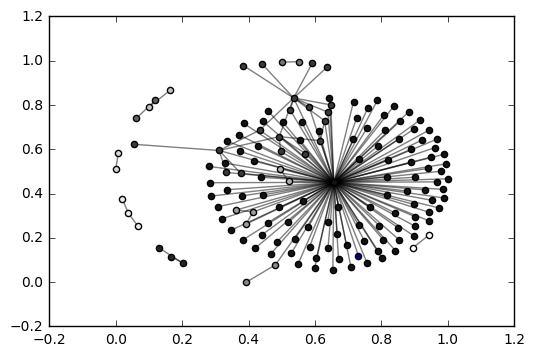

In [353]:
G=nx.from_pandas_dataframe(edgesId[['Sender', 'Recipient']], 'Sender', 'Recipient')

#first compute the best partition
partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))

nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

The community number corresponding to each person is retrieved from the partition created by the community.best_partition() method.

In [354]:
partition_frame = pd.Series(partition).reset_index()
partition_frame.columns = ['Name', 'Community_number']
partition_frame.head()

,Name,Community_number
0,ASUNCION,11
1,Alec,10
2,Andrew Shapiro,0
3,Anne-Marie Slaughter,0
4,Arturo Valenzuela,0


### Partition data processing
Now that the graph partition data have been determined, the emails with an empty body can be removed since they don't help for the topic modeling.

In [355]:
edges_community = pd.merge(edgesId, partition_frame, how='inner', left_on='Sender', right_on='Name')
edges_community = edges_community.drop(['Name'], axis=1)
edges_community = edges_community.dropna()
edges_community['ExtractedBodyText'] = edges_community['ExtractedBodyText'].apply(lambda x: x.lower())
print(edges_community.shape)
edges_community.head()

(6425, 4)


,ExtractedBodyText,Sender,Recipient,Community_number
1,fyi,Jake Sullivan,Hillary Clinton,2
2,fyi\nb6\n— —,Jake Sullivan,Hillary Clinton,2
3,fyi,Jake Sullivan,Hillary Clinton,2
4,this is nice.,Jake Sullivan,Hillary Clinton,2
5,b5,Jake Sullivan,Hillary Clinton,2


As it can be seen on the following table, the senders have been clustered into 8 different communities but a lot of them consist of only one or two persons.

In [384]:
community_groups = edges_community[['Sender', 'Community_number']].drop_duplicates()
community_groups_groupby = community_groups.groupby('Community_number')['Sender'].apply(lambda x: "%s" % ', '.join(x))
community_groups_groupby.to_frame().reset_index()

,Community_number,Sender
0,0,"Anne-Marie Slaughter, Harold Hongju Koh, Wendy..."
1,2,"Jake Sullivan, Cheryl Mills, Sidney Blumenthal..."
2,3,Neera Tanden
3,4,Chelsea Clinton
4,6,Jacob Lew
5,7,"Robert Russo, Betsy Ebeling"
6,8,"Lissa Muscatine, Daniel Baer"
7,12,Werner Ilic


Usual stopwords are used from the nltk.corpus library.

In [356]:
stopwordlist = stopwords.words('english')
stopwordlist.append("—")
stopwordlist.append("•")
stopwordlist.append("--")
stopwordlist.append("-")

The first function counts the number of occurences of each word from a DataFrame and returns a dictionnary word -> occurency. The second function takes a word -> occurency dictionnany and removes the key-value pairs present in the stopwords list.

In [357]:
def countWords(emails_body):
    emails_body.to_csv("hillary-clinton-emails/emails_body_clean.csv")
    with open("hillary-clinton-emails/emails_body_clean.csv") as data:
        wordcount = Counter(data.read().split())      
    return wordcount

def removeStopwords(wordcount):
    for stopword in stopwordlist:
        if wordcount[stopword] > 0:
            wordcount.pop(stopword, None)       
    return wordcount

### Results
The calculation of the word occurencies are performed on each community.

In [358]:
for commu in range(0,max(edges_community['Community_number']) + 1):
    emails_body_clean = edges_community[edges_community['Community_number'] == commu]['ExtractedBodyText']
    wordcount_clean = removeStopwords(countWords(emails_body_clean))
    wordcount_series = pd.Series(wordcount_clean)
    wordcount_sorted = wordcount_series.sort_values(ascending=False).to_frame()
    wordcount_sorted.columns = ['Number of appearances']
    if not wordcount_sorted.empty:
        print("Community number:", commu, "\n\n", wordcount_sorted.head(20), "\n\n")

Community number: 0 

        Number of appearances
would                    412
state                    367
w                        314
get                      278
u.s.                     271
call                     262
also                     249
see                      248
know                     244
new                      242
pm                       235
us                       224
2010                     208
one                      203
like                     195
women                    190
could                    187
i'm                      185
need                     183
work                     182 


Community number: 2 

              Number of appearances
pm                            1728
state                          999
would                          978
office                         855
new                            717
president                      676
one                            668
obama                          641
secretary's                